In [ ]:
import numpy as np
from numbers import Number
import torch
from torch.utils.data import Dataset, DataLoader
import os
os.add_dll_directory('C:\\Users\\Michael\\anaconda3\\lib\\site-packages\\dgl\\')
import dgl
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from os.path import join as oj
# paths/directories
data_dir = "data"

In [4]:
class MineDataset(Dataset):
    def __init__(
        self,
        data_dir,
        input_steps,
        output_steps,
        idx_list=None,
        transform=None,
    ):
        """User defined dataset that can be used for PyTorch DataLoader"""
        #loading dynamics
        saved_dynamics_array = pd.read_csv(oj(data_dir, 'saved_dynamics_array' + '.csv'))
        input_dynamics = saved_dynamics_array.loc[(saved_dynamics_array.run == 0)].pivot(index='timestep', columns='neuron', values='voltage').values
        for i in range(saved_dynamics_array["run"].max()):
            d1 = saved_dynamics_array.loc[(saved_dynamics_array.run == i+1)].pivot(index='timestep', columns='neuron', values='voltage').values
            input_dynamics = np.dstack((input_dynamics,d1))
        self.data = np.transpose(input_dynamics, (2, 0, 1))
        #print(input_dynamics.shape)

        self.E = -48.0 * np.load(oj(data_dir, 'emask_default.npy'))  # N x 1 directionality vector
        self.Gg_Static = np.load(oj(data_dir, 'Gg_default.npy'))  # N X N matrix of gap junction connections
        self.Gs_Static = np.load(oj(data_dir, 'Gs_default.npy'))  # N X N matrix of synaptic junction connections
        assert self.data.shape[2] == self.E.shape[0] == self.Gg_Static.shape[0] == self.Gs_Static.shape[0]
        
        assert len(self.data.shape) == 3 # n_recordings, time_steps, n_neurons
        self.total_time_steps = self.data.shape[1]
        self.input_steps = input_steps #e.g. 1 step, 2 etc before
        self.output_steps = output_steps
        self.t_cushion_in = 100 #cushion from beginning of timesteps
        self.t_cushion_out = 10
        assert self.input_steps <= self.t_cushion_in and self.output_steps <= self.t_cushion_out
        self.transform = transform
        if idx_list is None: #
            self.idx_list = np.arange(self.data.shape[0] * (self.total_time_steps - self.t_cushion_in - self.t_cushion_out)).tolist()
        else:
            self.idx_list = idx_list
        self.data_dir = data_dir
        
        #loading graph
        def get_conn_ids(adj_mat):
            '''returns source and target ids'''
            graph = nx.from_numpy_array(adj_mat)
            graph_edges = np.array(graph.edges())
            source_id,target_id = graph_edges[:,0],graph_edges[:,1]
            return(source_id,target_id, graph)
        
        source_id_electric,target_id_electric,saved_elec_graph = get_conn_ids(self.Gg_Static)
        source_id_chemical,target_id_chemical,saved_chem_graph = get_conn_ids(self.Gs_Static)
         
        graph_data = {
        ("neuron_basic", "electric", "neuron_basic"): (source_id_electric, target_id_electric),
        ("neuron_basic", "chemical", "neuron_basic"): (source_id_chemical, target_id_chemical),
        }

        self.g = dgl.heterograph(graph_data)
        #print(x.shape)
        self.g.edges['electric'].data['he'] = torch.FloatTensor([saved_elec_graph.get_edge_data(edge[0],edge[1])["weight"] for edge in saved_elec_graph.edges()])
        self.g.edges['chemical'].data['he'] = torch.FloatTensor([saved_chem_graph.get_edge_data(edge[0],edge[1])["weight"] for edge in saved_chem_graph.edges()])

        
    def __len__(self):
        return len(self.idx_list)

    def __getitem__(self, idx):
        """Obtain the idx 'th data of the dataset.'"""
        # Determine the type of the idx:
        is_list = True
        if isinstance(idx, torch.Tensor):
            if len(idx.shape) == 0 or (len(idx.shape) == 1 and len(idx) == 1):
                idx = idx.item()
                is_list = False
        elif isinstance(idx, list):
            pass
        elif isinstance(idx, Number):
            is_list = False

        # If idx is a list, return a dataset with 
        if isinstance(idx, slice) or is_list:
            #raise ValueError("index should not be slice")
            return [self[x] for x in self.idx_list[idx]]
#             return MineDataset(
#                 data_dir=self.data_dir,
#                 input_steps=self.input_steps,
#                 output_steps=self.output_steps,
#                 idx_list=self.idx_list[idx],
#                 transform=self.transform,
#            )

        sim_id, id = divmod(self.idx_list[idx], self.total_time_steps - self.t_cushion_in - self.t_cushion_out) 
        x = torch.FloatTensor(self.data[sim_id, id-self.input_steps+1+self.t_cushion_in: id+1+self.t_cushion_in]) #shape is input_steps, n_neurons
        y = torch.FloatTensor(self.data[sim_id, id+1+self.t_cushion_in: id+self.output_steps+1+self.t_cushion_in]) #shape is output_steps, n_neurons
        
        #append E
        E_expanded = torch.FloatTensor(self.E).repeat(1,self.input_steps) #shape is Nxinput_steps
        
        g = self.g.clone()
        g.nodes["neuron_basic"].data["feats"] = torch.stack([E_expanded,x.transpose(0,1)], 2) # shape is N x input_steps x 2
        g.nodes["neuron_basic"].data["labels"] = y.transpose(0,1)[:,:,None]
        
        
        #print(x.shape)
        #print(y.shape)
        if self.transform:
            g = self.transform(g)
        return g

    def __repr__(self):
        """Print name of the class."""
        return self.__class__.__name__ + f"({len(self)})"

In [5]:
if __name__ == "__main__":
    #data = np.random.randn(10, 1000, 302, 2)  # n_recordings, time_steps, n_neurons, n_features
    #data = data_dir
    #print(input_dynamics.shape)
    #graph = 
    
    dataset = MineDataset(
        data_dir=data_dir,
        input_steps=1, #4
        output_steps=1, #2
    )
    #print(dataset[1:3])
    #print(dataset[0].nodes["neuron_basic"].data["labels"].shape)
    #dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=Batch(is_absorb_batch=True).collate())
    #for data in dataloader:
    #    break
    #print(data.x.shape)

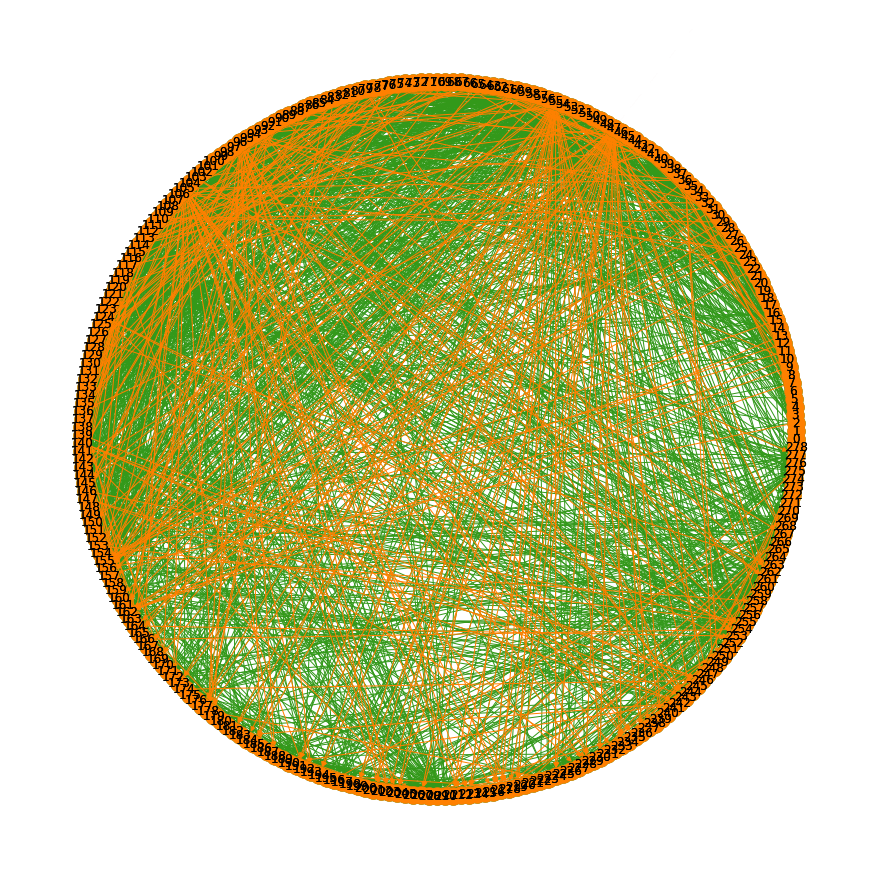

In [7]:
import networkx as nx
plt.figure(3,figsize=(12,12)) 

colors = {
    'electric' : [1, .5, 0],'chemical' : [.2, .6, .1],
}
for edge_type in ['chemical','electric',]:
    g = dgl.edge_type_subgraph(dataset[0], [('neuron_basic', edge_type, 'neuron_basic'),])

    # Since the actual graph is undirected, we convert it for visualization
    # purpose.
    # Copy edge features
    hg = dgl.to_homogeneous(g, edata=['he'])
    # Copy node features
    #hg = dgl.to_homogeneous(eg, ndata=['feats'])
    nx_G = hg.to_networkx().to_directed()
    #edge_colors = ['color1' if your_condition else 'color2' for e in nx_G.edges]
    # Kamada-Kawaii layout usually looks pretty for arbitrary graphs
    pos = nx.circular_layout(nx_G)

    nx.draw(nx_G, pos, with_labels=True, node_color=[colors[edge_type]],edge_color=[colors[edge_type]])

plt.show()

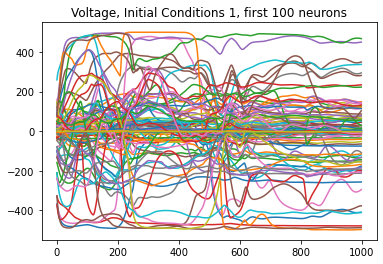

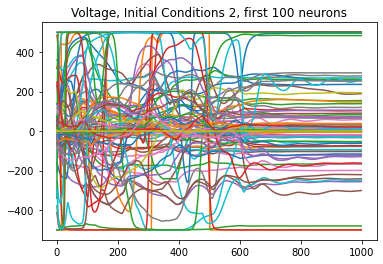

In [6]:
# plt.plot(dataset.data[0][:, 0:99]);
# plt.title('Voltage, Initial Conditions 1, first 100 neurons')
# plt.show();

# plt.plot(dataset.data[1][:, 0:99]);
# plt.title('Voltage, Initial Conditions 2, first 100 neurons')
# plt.show();